Simulation Parameters:

1. Calculate daily range
2. Set a lower threshold
3. Long entries are when the price closes in the bottom n% of the day's range, defined by the threshold
4. Measure how often this is followed by an upwards move
5. Run the simulation with various thresholds and graph

In [1]:
#import libraries
import yfinance as yf
import datetime
import numpy as np
from matplotlib import pyplot as plt

/Users/saurabhchopda/AlgoTrading/Stock-Prediction-Models/stock-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#define variables
SYMBOL = "AMZN"
PCT_THRESH = 20

In [3]:
#define date range
START = datetime.datetime(2022, 1, 1)
END = datetime.datetime.today()
YEARS = (END - START).days / 365.25

In [4]:
#download data
price = yf.download(SYMBOL, start=START, end=END)

price.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999,188.389999,27930800
2024-10-29,188.580002,191.460007,187.820007,190.830002,190.830002,35690200
2024-10-30,194.699997,195.610001,192.419998,192.729996,192.729996,37707600
2024-10-31,190.509995,190.600006,185.229996,186.399994,186.399994,75146800
2024-11-01,199.000000,200.500000,197.020004,197.929993,197.929993,99571700


In [5]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999
2024-10-29,188.580002,191.460007,187.820007,190.830002
2024-10-30,194.699997,195.610001,192.419998,192.729996
2024-10-31,190.509995,190.600006,185.229996,186.399994
2024-11-01,199.000000,200.500000,197.020004,197.929993


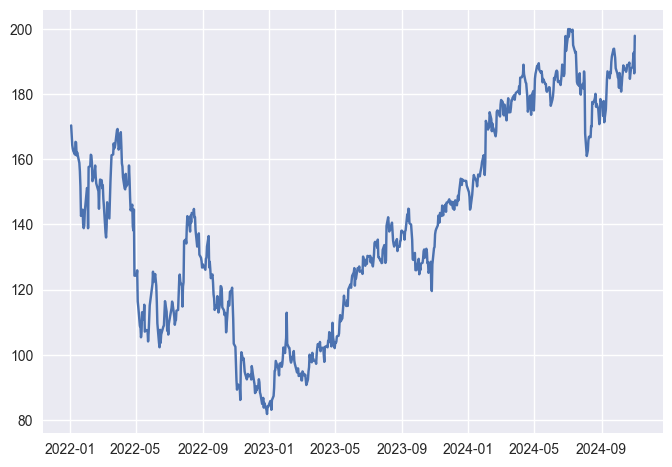

In [6]:
plt.style.use('seaborn-v0_8')
plt.plot(price.Close)

plt.show()

In [9]:
#calculate benchmark return
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1

#calculate daily range
price['Range'] = price.High - price.Low

#calculate distance from close to low
price['Dist'] = abs(price.Close - price.Low)

#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct,Long,Sys_Ret
Date,,,,,,,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999,1.002981,2.000000,0.179993,8.999634,True,1.002981
2024-10-29,188.580002,191.460007,187.820007,190.830002,1.012952,3.639999,3.009995,82.692171,False,1.012952
2024-10-30,194.699997,195.610001,192.419998,192.729996,1.009956,3.190002,0.309998,9.717784,True,1.000000
2024-10-31,190.509995,190.600006,185.229996,186.399994,0.967156,5.370010,1.169998,21.787633,False,0.967156
2024-11-01,199.000000,200.500000,197.020004,197.929993,1.061856,3.479996,0.909988,26.149124,False,1.000000


In [10]:
#entry triggers
price['Long'] = price.Pct < PCT_THRESH

#system return
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct,Long,Sys_Ret
Date,,,,,,,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999,1.002981,2.000000,0.179993,8.999634,True,1.002981
2024-10-29,188.580002,191.460007,187.820007,190.830002,1.012952,3.639999,3.009995,82.692171,False,1.012952
2024-10-30,194.699997,195.610001,192.419998,192.729996,1.009956,3.190002,0.309998,9.717784,True,1.000000
2024-10-31,190.509995,190.600006,185.229996,186.399994,0.967156,5.370010,1.169998,21.787633,False,0.967156
2024-11-01,199.000000,200.500000,197.020004,197.929993,1.061856,3.479996,0.909988,26.149124,False,1.000000


In [11]:
#benchmark up and down days
bench_win = price.Return[price.Return > 1.0].count()
bench_loss = price.Return[price.Return < 1.0].count()
bench_winrate = round((bench_win / (bench_win + bench_loss)) * 100, 2)

#extract the up and down days
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Winrate: {bench_winrate}%')
print('')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'System Winrate: {sys_winrate}%')

Benchmark Winrate: 51.34%

Trades Won: 87
Trades Loss: 66
System Winrate: 56.86%


In [12]:
def simulate(price, threshold):
    
    #entry triggers
    price['Long'] = price.Pct < threshold

    #system return
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)
    
    #extract the up and down days
    sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
    sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
    sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

    return sys_winrate

In [13]:
#blank list for backtest results
results = []
pct_range = range(5, 101)

for pct in pct_range:
    results.append(simulate(price, pct))

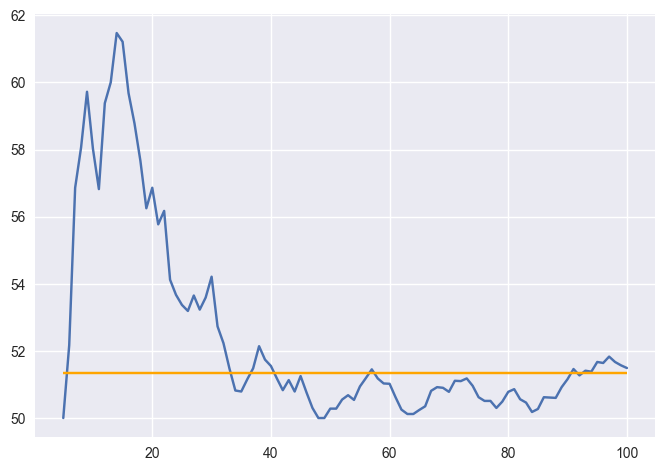

In [14]:
plt.plot(pct_range, results)
plt.hlines(bench_winrate, pct_range[0], pct_range[-1], colors = 'orange')

plt.show()

In [15]:
print(f'Max System Winrate: {max(results)}, at {pct_range[results.index((max(results)))]}')
print(f'Benchmark Winrate: {bench_winrate}')

Max System Winrate: 61.47, at 14
Benchmark Winrate: 51.34
